Some guidelines for Project3:


Get familiar with Vectorizer and all its hyperparameter. Check out the respective documentation: Count and Tf-IDF Vectorizer
Choose subreddits with sufficient posts - preferably active posts
Make sure posts are wordy - don't choose subreddits where posts are filled with media posts such images or youtube videos, then you may not have sufficient text data for classification.


Do check for duplicate posts as Reddit 'jams' your webscraping by giving you duplicate posts once you have scraped all the available posts or more than approximately 1000 posts.
In the preprocessing step, remove your subreddit topic, example: Marvel, DC, Samsung etc from the selftext and title columns to avoid target leakage. 

ref: https://h2o.ai/wiki/target-leakage/
You can vary your urls to get more posts by replacing 'top' and 'all' with other options in the lists : ['hot', 'controversial', 'new', 'top'], ['week','month', 'year', 'all']. 

Eg: https://www.reddit.com/r/boardgames/top.json?t=all&limit=25

The Goal of this project is to find distinct IronMan from Batman
which their both have similarity in many aspect Richman save people
- their both have hi-tech car, rich, and be a man
- their both distinct in wearable just iron man wear iron suit, batman wear pvc suit
- its hard for us to distinct these 2 with subreddit post 
- so out business is serious about split batman from ironman

via subreddit post only text too since image didn't included in this project concern



In [59]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import models need in this project
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier

# import tokenizer and relate tools
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag


### **Data Collection**

I create `sub_reddit_post_gathering` to gather post from any subredditwith 3 parameters that can configure
- `subreddit_name`
- `data_amount`
- `output_csv`
so you can collecting data in any sub reddit and any amout you want

but in this case I collected from `ironman`, `batman` for approximately `1_000` posts each 

and save file to `data/` folder

In [60]:
batman = pd.read_csv('../data/batman.csv')
print(batman.shape)
batman.head()

(1012, 116)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,post_hint,url_overridden_by_dest,preview,link_flair_template_id,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,author_cakeday
0,NaN,batman,**Welcome to the r/Batman Monthly Discussion T...,t2_6l4z3,False,NaN,0,False,Monthly r/Batman Discussion Thread - Posted on...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,batman,NaN,t2_v80xrv1k,False,NaN,0,False,Don’t turn him into a mcu character but he’s m...,"[{'e': 'text', 't': 'FUNNY'}]",...,image,https://i.redd.it/7a2phkaj57zb1.jpg,{'images': [{'source': {'url': 'https://previe...,d811bcc6-f576-11ed-970f-5217f775e7dd,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,batman,NaN,t2_hlci6d4q,False,NaN,0,False,Wtf did I just read,"[{'e': 'text', 't': 'GENERAL DISCUSSION'}]",...,NaN,https://www.reddit.com/gallery/17r0ifp,NaN,9920b510-f578-11ed-a075-fad5cce75268,True,"{'jnx31dxgx7zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'vd2znrwgx7zb1', 'id':...",NaN,NaN,NaN
3,NaN,batman,"Hi guys! Im new to the community,my name is Da...",t2_7k8r0ioo,False,NaN,0,False,“STAY” A Jim Gordon Short Story,"[{'e': 'text', 't': 'ARTWORK'}]",...,NaN,https://www.reddit.com/gallery/17qt2ht,NaN,5eb096ba-e07f-11ed-a1af-7a495b5b3295,True,"{'vck7couya6zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'e4thmouya6zb1', 'id':...",NaN,NaN,NaN
4,NaN,batman,NaN,t2_af6tp1tv,False,NaN,0,False,What is the Arkham Knight version,"[{'e': 'text', 't': 'GENERAL DISCUSSION'}]",...,image,https://i.redd.it/253wathr95zb1.jpg,{'images': [{'source': {'url': 'https://previe...,9920b510-f578-11ed-a075-fad5cce75268,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
print(batman.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Columns: 116 entries, approved_at_utc to author_cakeday
dtypes: bool(28), float64(26), int64(10), object(52)
memory usage: 723.6+ KB
None


In [62]:
ironman = pd.read_csv('../data/ironman.csv')
print(ironman.shape)
ironman.head()

(1019, 115)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,collections,is_gallery,media_metadata,gallery_data,author_cakeday
0,NaN,ironman,NaN,t2_d849tg4m,False,NaN,0,False,GoFundMe for Iron Man writer Len Kaminski is live,"[{'e': 'text', 't': 'Miscellaneous'}]",...,21018,1.684463e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,NaN,ironman,Following last month's monumental *Invincible ...,t2_d849tg4m,False,NaN,0,False,"Iron Man Comics for October 18th, 2023 - Discu...","[{'e': 'text', 't': 'Comics'}]",...,21018,1.697605e+09,0,NaN,False,[{'permalink': 'https://www.reddit.com/r/ironm...,NaN,NaN,NaN,NaN
2,NaN,ironman,NaN,t2_jdn1k4668,False,NaN,0,False,"One of the best ""I have to break my no-kill ru...","[{'e': 'text', 't': 'Comics'}]",...,21018,1.699489e+09,0,NaN,False,NaN,True,"{'fh7tg3f3u7zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'hbfqrq11u7zb1', 'id':...",NaN
3,NaN,ironman,NaN,t2_ekpe5dp8,False,NaN,0,False,TIL there was an anime version of Zeke Stane -...,"[{'e': 'text', 't': 'TV'}]",...,21018,1.699497e+09,0,NaN,False,NaN,True,"{'d8gtfrk7g8zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'd8gtfrk7g8zb1', 'id':...",NaN
4,NaN,ironman,https://youtu.be/9FEDbhepU9I?si=0nO-8Ku5lth35s...,t2_aslejun9m,False,NaN,0,False,Thanos #1 (feat Ironman),"[{'e': 'text', 't': 'Comics'}]",...,21018,1.699483e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN


In [63]:
print(ironman.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Columns: 115 entries, approved_at_utc to author_cakeday
dtypes: bool(28), float64(26), int64(10), object(51)
memory usage: 720.6+ KB
None


### **Data Cleaning and EDA**

In [64]:
batman.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,post_hint,url_overridden_by_dest,preview,link_flair_template_id,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,author_cakeday
0,NaN,batman,**Welcome to the r/Batman Monthly Discussion T...,t2_6l4z3,False,NaN,0,False,Monthly r/Batman Discussion Thread - Posted on...,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,batman,NaN,t2_v80xrv1k,False,NaN,0,False,Don’t turn him into a mcu character but he’s m...,"[{'e': 'text', 't': 'FUNNY'}]",...,image,https://i.redd.it/7a2phkaj57zb1.jpg,{'images': [{'source': {'url': 'https://previe...,d811bcc6-f576-11ed-970f-5217f775e7dd,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,batman,NaN,t2_hlci6d4q,False,NaN,0,False,Wtf did I just read,"[{'e': 'text', 't': 'GENERAL DISCUSSION'}]",...,NaN,https://www.reddit.com/gallery/17r0ifp,NaN,9920b510-f578-11ed-a075-fad5cce75268,True,"{'jnx31dxgx7zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'vd2znrwgx7zb1', 'id':...",NaN,NaN,NaN
3,NaN,batman,"Hi guys! Im new to the community,my name is Da...",t2_7k8r0ioo,False,NaN,0,False,“STAY” A Jim Gordon Short Story,"[{'e': 'text', 't': 'ARTWORK'}]",...,NaN,https://www.reddit.com/gallery/17qt2ht,NaN,5eb096ba-e07f-11ed-a1af-7a495b5b3295,True,"{'vck7couya6zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'e4thmouya6zb1', 'id':...",NaN,NaN,NaN
4,NaN,batman,NaN,t2_af6tp1tv,False,NaN,0,False,What is the Arkham Knight version,"[{'e': 'text', 't': 'GENERAL DISCUSSION'}]",...,image,https://i.redd.it/253wathr95zb1.jpg,{'images': [{'source': {'url': 'https://previe...,9920b510-f578-11ed-a075-fad5cce75268,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# remove unrelated columns
# batman.drop(columns=['approved_at_utc', 'author_fullname', 'saved', 'author', 'created_utc', 'mod_reason_title', 'clicked'], inplace=True)
# batman.drop(columns=['gilded', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'link_flair_css_class', 'downs', 'post_hint', 'link_flair_template_id'], inplace=True)
# batman.drop(columns=['thumbnail_height', 'top_awarded_type', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'url_overridden_by_dest', 'author_cakeday'], inplace=True)
# batman.drop(columns=['thumbnail_width', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail', 'author_flair_template_id'], inplace=True)
# batman.drop(columns=['author_flair_text_color', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post'], inplace=True)
# batman.drop(columns=['author_patreon_flair', 'author_flair_richtext', 'gildings', 'post_categories', 'author_flair_type', 'media_metadata', 'author_flair_text', 'author_flair_css_class'], inplace=True)

# after a lot of remove found out that only need 4 columns for this project
# so I will select columns only subreddit, selftext, title and created to use

<Axes: >

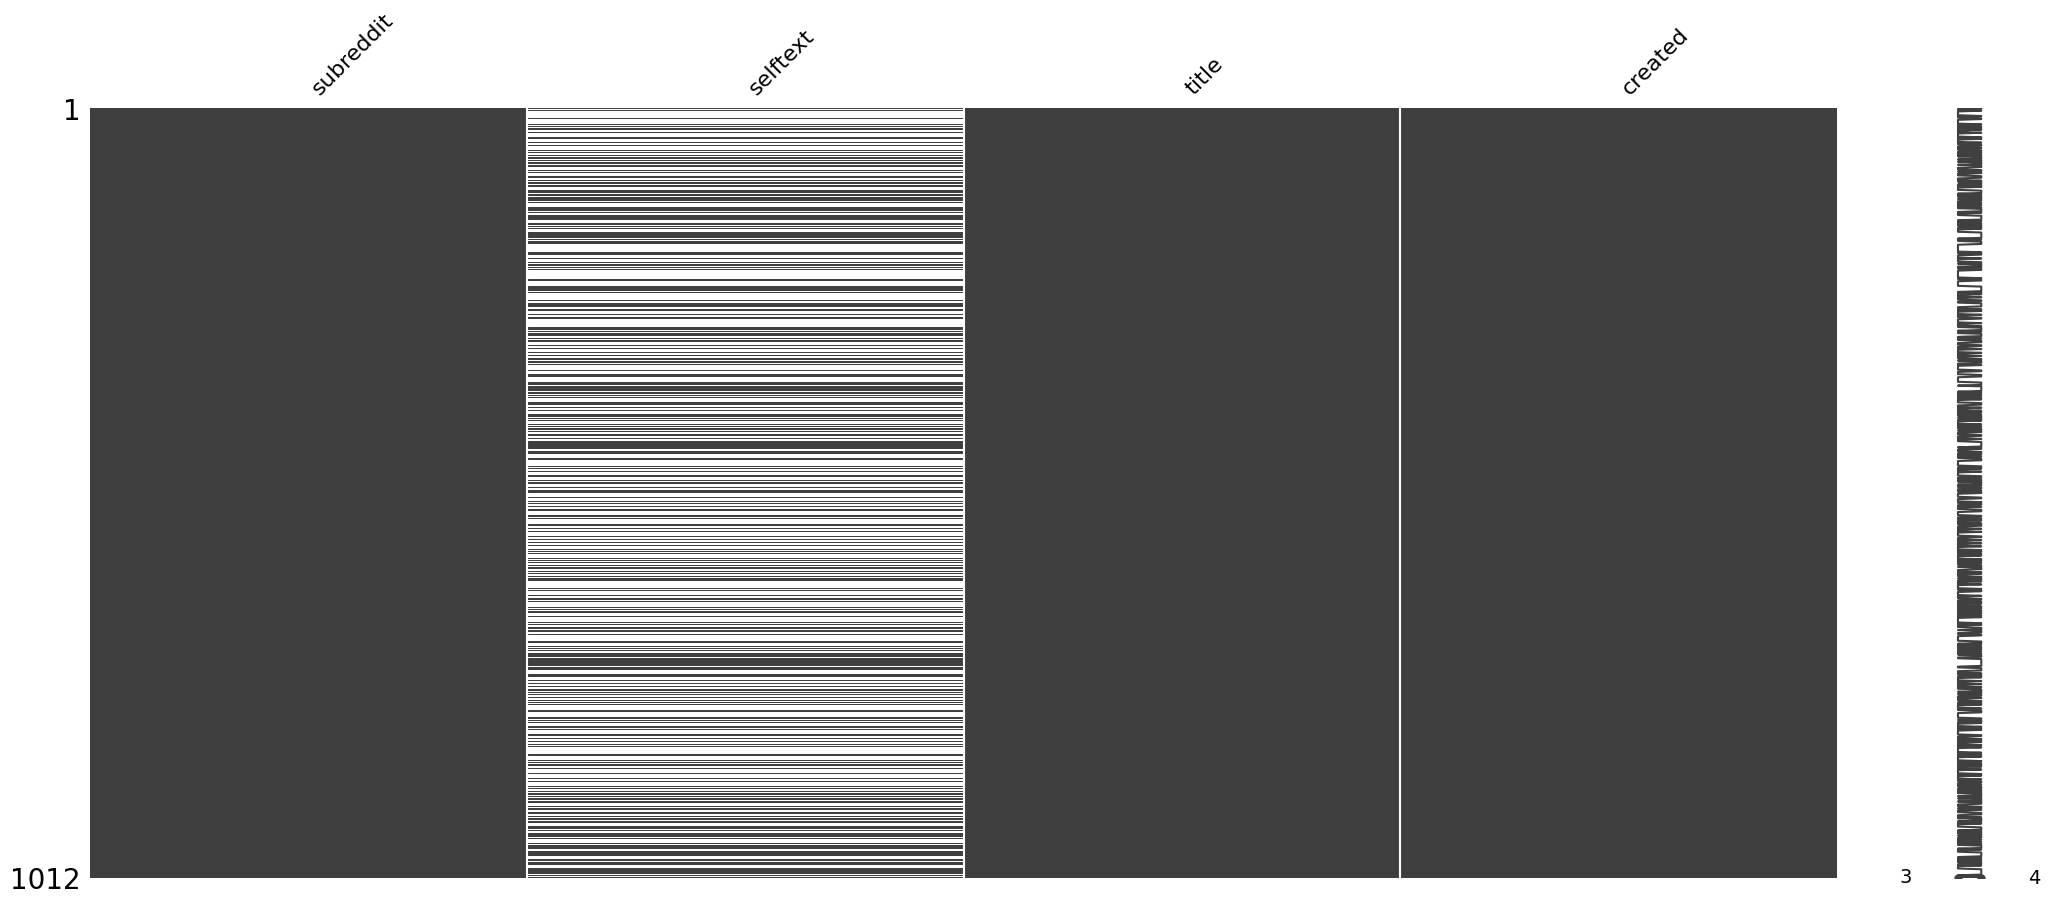

In [66]:
# find the missing value and clean it up
import missingno as msno
batman = batman[['subreddit', 'selftext', 'title', 'created']]
msno.matrix(batman)

In [67]:
batman.isnull().sum()

subreddit      0
selftext     572
title          0
created        0
dtype: int64

<Axes: >

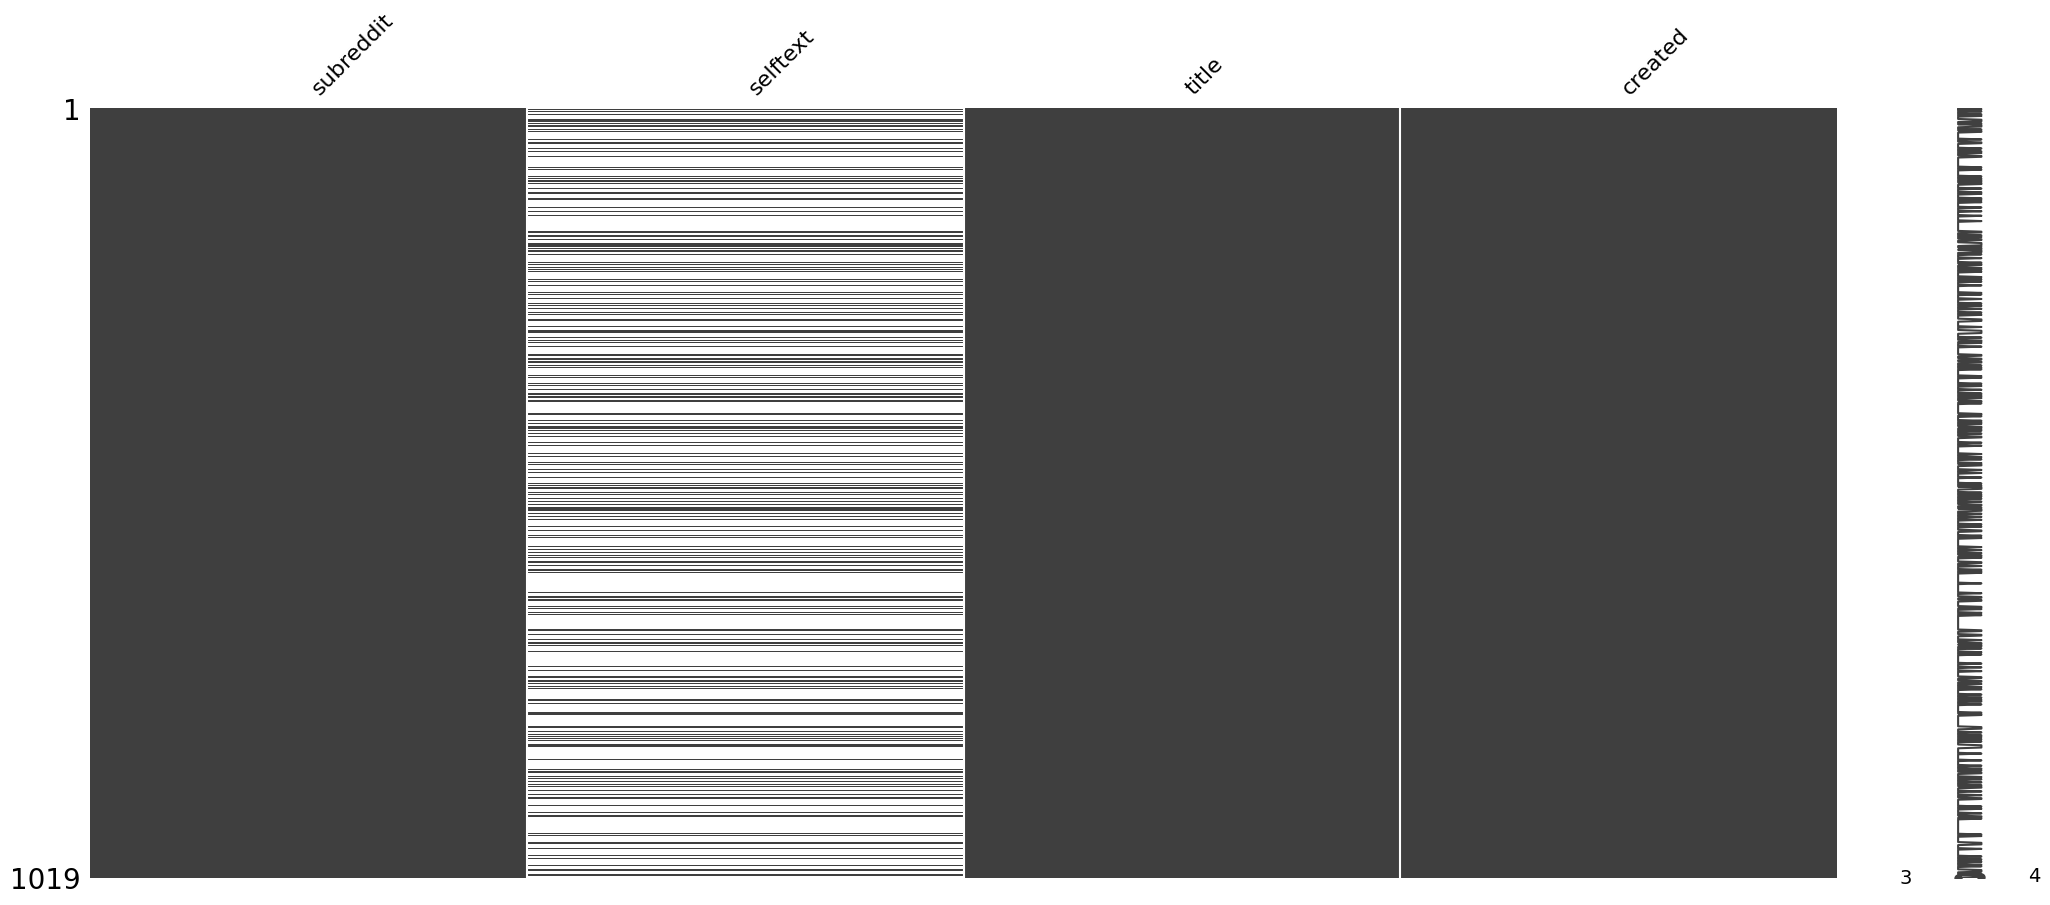

In [68]:
ironman = ironman[['subreddit', 'selftext',  'title', 'created']]
msno.matrix(ironman)

In [69]:
ironman.isna().sum()

subreddit      0
selftext     754
title          0
created        0
dtype: int64

as selftext cout as text content so I will sum up selftext and title into content column first

In [70]:
# Merge selftext, title into content
batman.fillna('', inplace=True)
batman['content'] = batman['title'] + batman['selftext']
batman['content'].head()

0    Monthly r/Batman Discussion Thread - Posted on...
1    Don’t turn him into a mcu character but he’s m...
2                                  Wtf did I just read
3    “STAY” A Jim Gordon Short StoryHi guys! Im new...
4                    What is the Arkham Knight version
Name: content, dtype: object

In [71]:
# Merge selftext, title into content
ironman.fillna('', inplace=True)
ironman['content'] = ironman['title'] + ironman['selftext']
ironman['content'].head()

0    GoFundMe for Iron Man writer Len Kaminski is live
1    Iron Man Comics for October 18th, 2023 - Discu...
2    One of the best "I have to break my no-kill ru...
3    TIL there was an anime version of Zeke Stane -...
4    Thanos #1 (feat Ironman)https://youtu.be/9FEDb...
Name: content, dtype: object

### ** Preprocessing **
- Is text data successfully converted to a matrix representation?
- Are methods such as stop words, stemming, and lemmatization explored?
- Does the student properly split and/or sample the data for validation/training purposes?
- Does the student test and evaluate a variety of models to identify a production algorithm (**AT MINIMUM:** Naive Bayes and Random Forest)?
- Does the student defend their choice of production model relevant to the data at hand and the problem?
- Does the student explain how the model works and evaluate its performance successes/downfalls?

### Clear leak information
remove your subreddit topic, example: Marvel, DC, Samsung etc from the selftext and title columns to avoid target leakage. 


In [72]:
import regex as re

batman.content = batman.content.apply(lambda x: re.sub(r'batman|bat man', '', x, flags=re.IGNORECASE))
ironman.content = ironman.content.apply(lambda x: re.sub(r'ironman|iron man', '', x, flags=re.IGNORECASE))


In [73]:
ironman.head()

,subreddit,selftext,title,created,content
0,ironman,,GoFundMe for Iron Man writer Len Kaminski is live,1.684463e+09,GoFundMe for writer Len Kaminski is live
1,ironman,Following last month's monumental *Invincible ...,"Iron Man Comics for October 18th, 2023 - Discu...",1.697605e+09,"Comics for October 18th, 2023 - Discussion Th..."
2,ironman,,"One of the best ""I have to break my no-kill ru...",1.699489e+09,"One of the best ""I have to break my no-kill ru..."
3,ironman,,TIL there was an anime version of Zeke Stane -...,1.699497e+09,TIL there was an anime version of Zeke Stane -...
4,ironman,https://youtu.be/9FEDbhepU9I?si=0nO-8Ku5lth35s...,Thanos #1 (feat Ironman),1.699483e+09,Thanos #1 (feat )https://youtu.be/9FEDbhepU9I?...


In [74]:
batman.head()

,subreddit,selftext,title,created,content
0,batman,**Welcome to the r/Batman Monthly Discussion T...,Monthly r/Batman Discussion Thread - Posted on...,1.698833e+09,Monthly r/ Discussion Thread - Posted on the 1...
1,batman,,Don’t turn him into a mcu character but he’s m...,1.699481e+09,Don’t turn him into a mcu character but he’s m...
2,batman,,Wtf did I just read,1.699490e+09,Wtf did I just read
3,batman,"Hi guys! Im new to the community,my name is Da...",“STAY” A Jim Gordon Short Story,1.699471e+09,“STAY” A Jim Gordon Short StoryHi guys! Im new...
4,batman,,What is the Arkham Knight version,1.699458e+09,What is the Arkham Knight version


In [75]:
# check dupplicate
batman.duplicated().sum()

176

In [76]:
# remove dupplicate
batman.drop_duplicates(inplace=True)

In [77]:
# check dupplicate again
batman.duplicated().sum()

0

In [78]:
# check dupplicate
ironman.duplicated().sum()

27

In [79]:
# remove dupplicate
ironman.drop_duplicates(inplace=True)

In [80]:
# check dupplicate again
ironman.duplicated().sum()

0

In [81]:
# let's prepare data set for modeling
# create target variable
batman['target'] = 0
ironman['target'] = 1

# combine two data set
df = pd.concat([batman, ironman], ignore_index=True)
print(df.shape)
df.info()


(1828, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   subreddit  1828 non-null   object 
 1   selftext   1828 non-null   object 
 2   title      1828 non-null   object 
 3   created    1828 non-null   float64
 4   content    1828 non-null   object 
 5   target     1828 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 85.8+ KB


In [82]:
df.head()

,subreddit,selftext,title,created,content,target
0,batman,**Welcome to the r/Batman Monthly Discussion T...,Monthly r/Batman Discussion Thread - Posted on...,1.698833e+09,Monthly r/ Discussion Thread - Posted on the 1...,0
1,batman,,Don’t turn him into a mcu character but he’s m...,1.699481e+09,Don’t turn him into a mcu character but he’s m...,0
2,batman,,Wtf did I just read,1.699490e+09,Wtf did I just read,0
3,batman,"Hi guys! Im new to the community,my name is Da...",“STAY” A Jim Gordon Short Story,1.699471e+09,“STAY” A Jim Gordon Short StoryHi guys! Im new...,0
4,batman,,What is the Arkham Knight version,1.699458e+09,What is the Arkham Knight version,0


In [83]:
# Create X, y variables
X = df[['content']]
y = df['target']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [84]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2.1 Multinomial Naive Bayes (estimator)
# 2.2 Random Forest classifiers (estimator)

pipe_rf = Pipeline([
    ('cvec', CountVectorizer),
    ('rf', RandomForestClassifier)
])

pipe_mnb = Pipeline([
    ('cvec', CountVectorizer),
    ('mnb', MultinomialNB)
])

# Set up a gridsearch for each model
pipe_rf_params = {
  'cvec__max_features': [1000, 2000, 3000],
  'cvec__min_df': [2, 3],
  'cvec__max_df': [.9, .95],
  'cvec__ngram_range': [(1,1), (1,2)],
  'rf__n_estimators': [100, 150],
  'rf__max_depth': [None, 1, 2, 3, 4, 5],
  'rf__min_samples_split': [2, 3, 4]
}

pipe_mnb_params = {
  'cvec__max_features': [1000, 2000, 3000],
  'cvec__min_df': [2, 3],
  'cvec__max_df': [.9, .95],
  'cvec__ngram_range': [(1,1), (1,2)],
  'mnb__alpha': [1, 2]
}


#### Prep content with `my_tokenize`
- with custom tokenize
- lowercase
- trim string
- remove html, emoji
- lemmatize
- stopwords
- word_tokenize

In [85]:
import re, emoji, urllib, html
from pythainlp.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def my_old_tokenize(text):
    text = text.lower()
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE ###
    text = re.sub(r'[“”„\"]', '', text) # remove double quotations
    text = re.sub(r'[‘’′′′′`\']', '', text) # remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token.strip('(').strip(')') for token in tokens]
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-zก-๙\.]*', token) and token not in stop_words ]
    return tokens

In [86]:
import re, emoji, urllib, html
from pythainlp.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def my_tokenize(text):
    text = text.lower()
    ### REMOVE URL ###
    text = html.unescape(urllib.parse.unquote(text)) # unescape for unicode, unquote for escaped URL
    text = re.sub(r'https?.+?(?:\s|$)', '', text) # remove URL link
    ### REMOVE EMOJI ###
    text = emoji.replace_emoji(text) # remove emoji
    ### REPLACE ###
    text = re.sub(r'[“”„\"]', '', text) # remove double quotations
    text = re.sub(r'[‘’′′′′`\']', '', text) # remove single quotations
    text = re.sub(r'[\n\t\u00a0\xa0\u3000\u2002-\u200a\u202f]+', ' ', text) # shrink whitespaces e.g. good  boy -> good boy
    text = re.sub(r'[\r\u200b\ufeff]+', '', text) # remove non-breaking space
    text = re.sub(r'\u0E33([\u0E48\u0E49\u0E4A\u0E4B])', r'\1'+'\u0E33', text) # am + tone -> tone + am
    text = re.sub(r'[\[\]]', '', text) # [what] -> what # newly add here
    ### TOKENIZE AND FILTERING ###
    tokens = word_tokenize(text, keep_whitespace=False)
    tokens = [token.strip('(').strip(')') for token in tokens]
    tokens = [token for token in tokens if re.match(r'[A-zก-ไ][A-zก-๙\.]*', token) and token not in stop_words ]
    return tokens

In [87]:
re.sub(r'[\[\]]', '', '[what]') # [what] -> what

'what'

In [88]:
# test my_tokenize
print(batman.content[0])
print(' '.join(my_tokenize(batman.content[0])))

Monthly r/ Discussion Thread - Posted on the 1st of Every Month!**Welcome to the r/ Monthly Discussion Thread!**

In an effort to improve the quality of content in r/, we are going to be limiting some commonly posted topics to these weekly discussion threads. Examples of such topics are:

- Asking for thoughts on an adaptation of a character for a movie or show that has been out for more than one year
- Asking people's thoughts on a recent movie or other adaptation
- Arguing that " has always killed" 
- "Who would win" topics, which might be better suited to r/whowouldwin
- Asking people's favorite episodes of a show
- Asking people's favorite or least favorite villains, sidekicks, or other types of characters
- Character comparison posts
- "Erase one' posts

The above list is not complete, and contains just a few common examples. The list will be expanded over time, but ultimately topics moved to weekly discussion threads are subject to moderator discretion.

**For a list of recommend

### investigate tokenize data with Tokenizer

<Axes: >

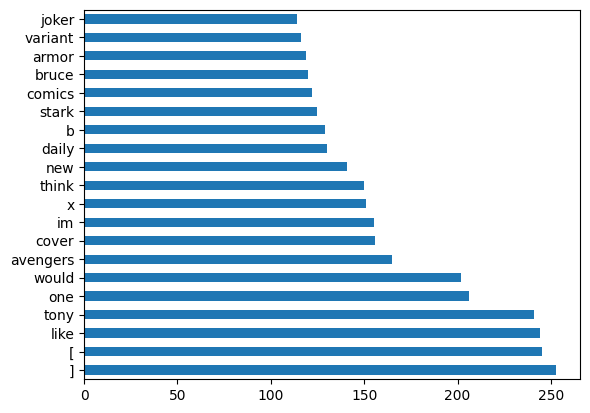

In [89]:
# old tokenization before add new rules
token_string = X_train['content'].map(my_old_tokenize)
words = []
for string in token_string:
  for word in string:
    if word not in stop_words:
      words.append(word)

words = pd.Series(words)
words.value_counts().head(20).plot(kind='barh')

#### Found that `[` and `]` have a lot frequency and no useful information so will add new rules to remove in  `my_tokenizer`

<Axes: >

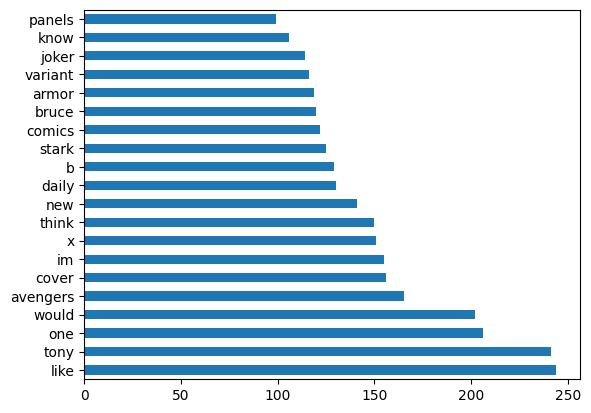

In [90]:
token_string = X_train['content'].map(my_tokenize)
words = []
for string in token_string:
  for word in string:
    if word not in stop_words:
      words.append(word)

words = pd.Series(words)
words.value_counts().head(20).plot(kind='barh')

In [91]:
cvec = CountVectorizer(tokenizer=my_tokenize, token_pattern=None)
# cvec = CountVectorizer()
cvec.fit(X_train['content'])
test_cvec = cvec.transform(X_train['content'])
cvec.get_feature_names_out()
cvec_df = pd.DataFrame(test_cvec.todense(), columns=cvec.get_feature_names_out())
cvec_df.head()

,\,\#,\*,\*.,\*\*\*\*\*\*,\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_,^,^_^,^_~,_,...,zemo,zero,zimbabwean,zodiac,zombie,zone,zsasz,zsjl,zur,zur-en-arrh
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
tf = TfidfVectorizer(tokenizer=my_tokenize, token_pattern=None)

# tf = TfidfVectorizer()
tf.fit(X_train['content'])
test_tf = tf.transform(X_train['content'])
tf_df = pd.DataFrame(test_tf.toarray(), columns=tf.get_feature_names_out())
tf_df.head()

,\,\#,\*,\*.,\*\*\*\*\*\*,\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_,^,^_^,^_~,_,...,zemo,zero,zimbabwean,zodiac,zombie,zone,zsasz,zsjl,zur,zur-en-arrh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pipeline modeling to check all parameters scope to find best params

In [93]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2.1 Multinomial Naive Bayes (estimator)
# 2.2 Random Forest classifiers (estimator)

cvec = CountVectorizer(tokenizer=my_tokenize, token_pattern=None)
mnb = MultinomialNB()
rf = RandomForestClassifier()

pipe_rf = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe_mnb = Pipeline([
    ('cvec', cvec),
    ('mnb', mnb)
])

# Set up a gridsearch for each model
pipe_rf_params = {
  'cvec__max_features': [1000, 2000, 3000],
  'cvec__min_df': [3],
  'cvec__max_df': [.9, .95],
  'cvec__ngram_range': [(1,2)],
  'rf__n_estimators': [100, 150, 200],
  'rf__max_depth': [None, 1, 5],
  'rf__min_samples_split': [2, 3, 4]
}

pipe_mnb_params = {
  'cvec__max_features': [1000, 2000, 3000],
  'cvec__min_df': [2, 3],
  'cvec__max_df': [.9, .95],
  'cvec__ngram_range': [(1,2)],
  'mnb__alpha': [1, 2]
}


In [94]:
# Instantiate GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid=pipe_rf_params, cv=5, verbose=1)
gs_mnb = GridSearchCV(pipe_mnb, param_grid=pipe_mnb_params, cv=5, verbose=1)

In [95]:
# do gridsearch for random forest
gs_rf.fit(X_train['content'], y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [ ]:
print(gs_rf.best_params_)
gs_rf.best_score_

{'cvec__max_df': 0.95, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'rf__max_depth': None, 'rf__min_samples_split': 3, 'rf__n_estimators': 100}


0.8541181154611811

In [ ]:
gs_rf.score(X_train['content'], y_train), gs_rf.score(X_test['content'], y_test)

(0.9890590809628009, 0.8402625820568927)

In [ ]:
rf_pred = gs_rf.predict(X_test['content'])

Text(0, 0.5, 'Actual Iron man 1')

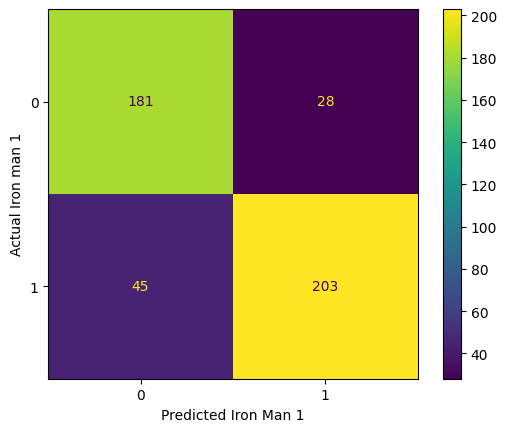

In [ ]:
# examine the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, rf_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Random Forest with CountVectorizer')
plt.xlabel('Predicted Iron Man 1')
plt.ylabel('Actual Iron man 1')

In [ ]:
# check f1 score since in this case didn't have much different between precision and recall
# also precision and recall are both important in this case
from sklearn.metrics import f1_score
f1_score(y_test, rf_pred)

0.8475991649269312

In [ ]:
# do gridsearch for multinomial naive bayes
gs_mnb.fit(X_train['content'], y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenize at 0x2b2a5a8e0>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [2, 3], 'cvec__ngram_range': [(1, 2)],
                         'mnb__alpha': [1, 2]},
             verbose=1)

In [ ]:
print(gs_mnb.best_params_)
gs_mnb.best_score_

{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'mnb__alpha': 2}


0.8563264764432648

In [ ]:
gs_mnb.score(X_train['content'], y_train), gs_mnb.score(X_test['content'], y_test)

(0.912472647702407, 0.8708971553610503)

Text(0, 0.5, 'Actual Iron man 1')

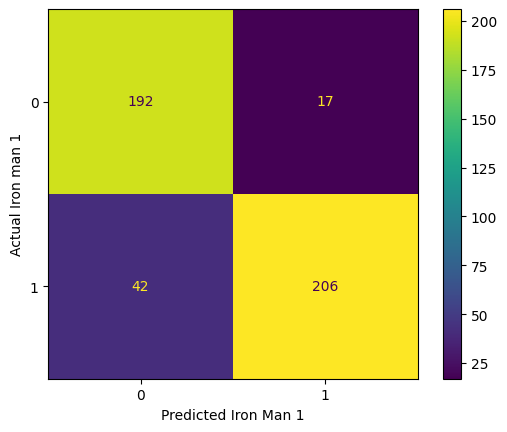

In [ ]:
# examine the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

mnb_pred = gs_mnb.predict(X_test['content'])
cm = confusion_matrix(y_test, mnb_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Multinomial Naive Bayes with CountVectorizer')
plt.xlabel('Predicted Iron Man 1')
plt.ylabel('Actual Iron man 1')

In [ ]:
# check f1 score since in this case didn't have much different between precision and recall
# also precision and recall are both important in this case
from sklearn.metrics import f1_score
f1_score(y_test, mnb_pred)

0.8747346072186837

In [ ]:
# lets compare between two models with DataFrame
# create dataframe for random forest
rf_df = pd.DataFrame({
    'model': ['Random Forest'],
    'tokenizer': ['Count Vectorizer'],
    'best_params': [gs_rf.best_params_],
    'train_score': [gs_rf.score(X_train['content'], y_train)],
    'test_score': [gs_rf.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, rf_pred)]
})
# create dataframe for mnb test
mnb_df = pd.DataFrame({
    'model': ['Multinomial Naive Bayes'],
    'tokenizer': ['Count Vectorizer'],
    'best_params': [gs_mnb.best_params_],
    'train_score': [gs_mnb.score(X_train['content'], y_train)],
    'test_score': [gs_mnb.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, mnb_pred)]
})
results_df = pd.concat([rf_df, mnb_df], ignore_index=True)
results_df


,model,tokenizer,best_params,train_score,test_score,f1_score
0,Random Forest,Count Vectorizer,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.989059,0.840263,0.847599
1,Multinomial Naive Bayes,Count Vectorizer,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.912473,0.870897,0.874735


In [ ]:
# let's try to use tfidf vectorizer
# Let's set a pipeline up with two stages:
# 1. tfidfVectorizer (transformer)
# 2.1 Multinomial Naive Bayes (estimator)
# 2.2 Random Forest classifiers (estimator)

tfidf = TfidfVectorizer(tokenizer=my_tokenize, token_pattern=None)
mnb = MultinomialNB()
rf = RandomForestClassifier()

pipe_rf_tf = Pipeline([
    ('tfidf', tfidf),
    ('rf', rf)
])

pipe_mnb_tf = Pipeline([
    ('tfidf', tfidf),
    ('mnb', mnb)
])

# Set up a gridsearch for each model
# use best params from before to scope down params
pipe_rf_tf_params = {
  'tfidf__max_features': [1000, 2000, 3000],
  'tfidf__min_df': [2, 3],
  'tfidf__max_df': [.9, .95],
  'tfidf__ngram_range': [(1,2)],
  'rf__n_estimators': [100, 150],
  'rf__max_depth': [None, 1, 5],
  'rf__min_samples_split': [2, 3, 4]
}

pipe_mnb_tf_params = {
  'tfidf__max_features': [1000, 2000, 3000],
  'tfidf__min_df': [2, 3],
  'tfidf__max_df': [.9, .95],
  'tfidf__ngram_range': [(1,2)],
  'mnb__alpha': [1, 2]
}


In [ ]:
# Instantiate GridSearchCV.
gs_rf_tf = GridSearchCV(pipe_rf_tf, param_grid=pipe_rf_tf_params, cv=5, verbose=1)
gs_mnb_tf = GridSearchCV(pipe_mnb_tf, param_grid=pipe_mnb_tf_params, cv=5, verbose=1)

In [ ]:
# fit gridsearch for random forest
gs_rf_tf.fit(X_train['content'], y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenize at 0x2b2a5a8e0>)),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 1, 3, 5],
                         'rf__min_samples_split': [2, 3, 4],
                         'rf__n_estimators': [100, 150],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=1)

In [ ]:
print(gs_rf_tf.best_params_)
gs_rf_tf.best_score_

{'rf__max_depth': None, 'rf__min_samples_split': 3, 'rf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


0.8606768414067684

In [ ]:
gs_rf_tf.score(X_train['content'], y_train), gs_rf_tf.score(X_test['content'], y_test)

(0.9912472647702407, 0.8424507658643327)

Text(0, 0.5, 'Actual Iron man 1')

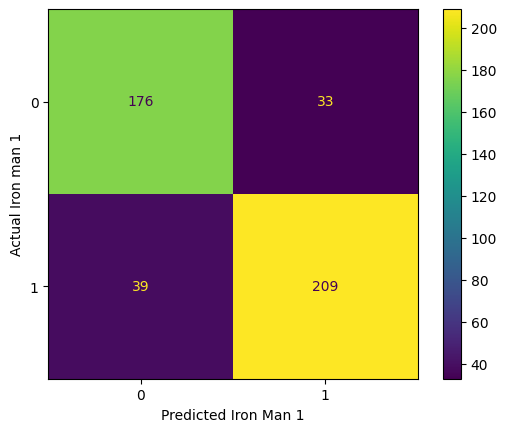

In [ ]:
# check confusion matrix
rf_tf_pred = gs_rf_tf.predict(X_test['content'])
cm = confusion_matrix(y_test, rf_tf_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Random Forest with TfidfVectorizer')
plt.xlabel('Predicted Iron Man 1')
plt.ylabel('Actual Iron man 1')

In [ ]:
# check f1 score
f1_score(y_test, rf_tf_pred)

0.8530612244897959

In [ ]:
# run gridsearch for multinomial naive bayes
gs_mnb_tf.fit(X_train['content'], y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenize at 0x2b2a5a8e0>)),
                                       ('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': [1, 2], 'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=1)

In [ ]:
print(gs_mnb_tf.best_params_)
gs_mnb_tf.best_score_

{'mnb__alpha': 2, 'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


0.8585003317850033

In [ ]:
gs_mnb_tf.score(X_train['content'], y_train), gs_mnb_tf.score(X_test['content'], y_test)

(0.9591539022611233, 0.8730853391684902)

In [ ]:
mnb_tf_pred = gs_mnb_tf.predict(X_test['content'])
cm = confusion_matrix(y_test, mnb_tf_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('Multinomial Naive Bayes with TF-IDF')
plt.xlabel('Predicted Iron Man 1')
plt.ylabel('Actual Iron man 1')

NameError: name 'gs_mnb_tf' is not defined

In [ ]:
# check f1 score
f1_score(y_test, mnb_tf_pred)

0.8839999999999999

In [ ]:
rf_df = pd.DataFrame({
    'model': ['Random Forest Count Vectorizer'],
    'tokenizer': ['Count Vectorizer'],
    'best_params': [gs_rf.best_params_],
    'train_score': [gs_rf.score(X_train['content'], y_train)],
    'test_score': [gs_rf.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, gs_rf.predict(X_test['content']))]
})
# create dataframe for mnb test
mnb_df = pd.DataFrame({
    'model': ['Multinomial Naive Bayes Count Vectorizer'],
    'tokenizer': ['Count Vectorizer'],
    'best_params': [gs_mnb.best_params_],
    'train_score': [gs_mnb.score(X_train['content'], y_train)],
    'test_score': [gs_mnb.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, gs_mnb.predict(X_test['content']))]
})
rf_tf_df = pd.DataFrame({
    'model': ['Random Forest tfidfVectorizer'],
    'tokenizer': ['tfidfVectorizer'],
    'best_params': [gs_rf_tf.best_params_],
    'train_score': [gs_rf_tf.score(X_train['content'], y_train)],
    'test_score': [gs_rf_tf.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, gs_rf_tf.predict(X_test['content']))]
})
# create dataframe for mnb test
mnb_tf_df = pd.DataFrame({
    'model': ['Multinomial Naive Bayes tfidfVectorizer'],
    'tokenizer': ['tfidfVectorizer'],
    'best_params': [gs_mnb_tf.best_params_],
    'train_score': [gs_mnb_tf.score(X_train['content'], y_train)],
    'test_score': [gs_mnb_tf.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, gs_mnb_tf.predict(X_test['content']))]
})
results_df = pd.concat([rf_df, mnb_df, rf_tf_df, mnb_tf_df], ignore_index=True)
results_df

,model,tokenizer,best_params,train_score,test_score,f1_score
0,Random Forest Count Vectorizer,Count Vectorizer,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.989059,0.840263,0.847599
1,Multinomial Naive Bayes Count Vectorizer,Count Vectorizer,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.912473,0.870897,0.874735
2,Random Forest tfidfVectorizer,tfidfVectorizer,"{'rf__max_depth': None, 'rf__min_samples_split...",0.991247,0.842451,0.853061
3,Multinomial Naive Bayes tfidfVectorizer,tfidfVectorizer,"{'mnb__alpha': 2, 'tfidf__max_df': 0.9, 'tfidf...",0.959154,0.873085,0.884000


after improve `my_tokenizer` f1_Score is better than 

the `my_old_tokenize` results below

![result before new tokenize](images/result-before-new-tokenize.png "result before new tokenize")

In [ ]:
# initial SVC model with tfidf vectorizer

from sklearn.svm import SVC
svc = SVC()
tfidf = TfidfVectorizer(tokenizer=my_tokenize, token_pattern=None)
pipe_svc = Pipeline([
    ('tfidf', tfidf),
    ('svc', svc)
])
gs_svc_tf = GridSearchCV(pipe_svc, param_grid={
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,2)],
    'svc__C': [1, 2],
    'svc__kernel': ['rbf', 'linear']
}, cv=5, verbose=1)

gs_svc_tf.fit(X_train['content'], y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenize at 0x2b2a5a8e0>)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 2], 'svc__kernel': ['rbf', 'linear'],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [1000, 2000, 3000],
                         'tfidf__min_df': [2, 3],
                         'tfidf__ngram_range': [(1, 2)]},
             verbose=1)

In [ ]:
print(gs_svc_tf.best_params_)
gs_svc_tf.best_score_

{'svc__C': 1, 'svc__kernel': 'rbf', 'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


0.8555726609157267

In [ ]:
gs_svc_tf.score(X_train['content'], y_train), gs_svc_tf.score(X_test['content'], y_test)

(0.9883296863603209, 0.8512035010940919)

In [ ]:
f1_score(y_test, gs_svc_tf.predict(X_test['content']))

0.8565400843881857

Text(0, 0.5, 'Actual Iron man 1')

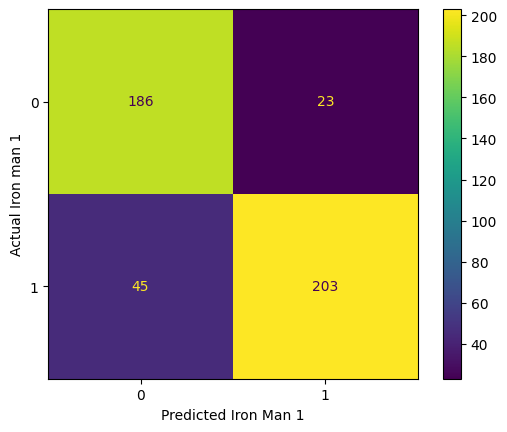

In [ ]:
gs_svc_tf_pred = gs_svc_tf.predict(X_test['content'])
cm = confusion_matrix(y_test, gs_svc_tf_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('SVC with TF-IDF')
plt.xlabel('Predicted Iron Man 1')
plt.ylabel('Actual Iron man 1')

In [ ]:
# initial SVC model with count vectorizer
from sklearn.svm import SVC
svc = SVC()
cvec = CountVectorizer(tokenizer=my_tokenize, token_pattern=None)
pipe_svc = Pipeline([
    ('cvec', cvec),
    ('svc', svc)
])
gs_svc = GridSearchCV(pipe_svc, param_grid={
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,2)],
    'svc__C': [1, 2],
    'svc__kernel': ['rbf', 'linear']
}, cv=5, verbose=1)
gs_svc.fit(X_train['content'], y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(token_pattern=None,
                                                        tokenizer=<function my_tokenize at 0x2b2a5a8e0>)),
                                       ('svc', SVC())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [2, 3], 'cvec__ngram_range': [(1, 2)],
                         'svc__C': [1, 2], 'svc__kernel': ['rbf', 'linear']},
             verbose=1)

In [ ]:
print(gs_svc.best_params_)
gs_svc.best_score_

{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'svc__C': 2, 'svc__kernel': 'rbf'}


0.8366237558062375

In [ ]:
gs_svc.score(X_train['content'], y_train), gs_svc.score(X_test['content'], y_test)

(0.9095550692924872, 0.811816192560175)

In [ ]:
f1_score(y_test, gs_svc.predict(X_test['content']))

0.7981220657276995

Text(0, 0.5, 'Actual Iron man 1')

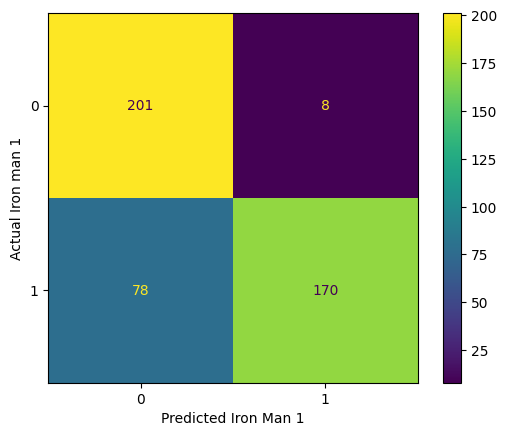

In [ ]:
# confusion matrix display
gs_svc_pred = gs_svc.predict(X_test['content'])
cm = confusion_matrix(y_test, gs_svc_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title('SVC with Count Vectorizer')
plt.xlabel('Predicted Iron Man 1')
plt.ylabel('Actual Iron man 1')

In [ ]:
# collect score to dataframe
results_df = pd.concat([results_df, pd.DataFrame({
    'model': ['SVC tfidfVectorizer'],
    'tokenizer': ['tfidfVectorizer'],
    'best_params': [gs_svc_tf.best_params_],
    'train_score': [gs_svc_tf.score(X_train['content'], y_train)],
    'test_score': [gs_svc_tf.score(X_test['content'], y_test)],
    'f1_score': [f1_score(y_test, gs_svc_tf.predict(X_test['content']))]
})], ignore_index=True)

In [ ]:
# sort by value f1_score
results_df.sort_values(by='f1_score', ascending=False)

,model,tokenizer,best_params,train_score,test_score,f1_score
3,Multinomial Naive Bayes tfidfVectorizer,tfidfVectorizer,"{'mnb__alpha': 2, 'tfidf__max_df': 0.9, 'tfidf...",0.959154,0.873085,0.884000
1,Multinomial Naive Bayes Count Vectorizer,Count Vectorizer,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.912473,0.870897,0.874735
4,SVC tfidfVectorizer,tfidfVectorizer,"{'svc__C': 1, 'svc__kernel': 'rbf', 'tfidf__ma...",0.988330,0.851204,0.856540
2,Random Forest tfidfVectorizer,tfidfVectorizer,"{'rf__max_depth': None, 'rf__min_samples_split...",0.991247,0.842451,0.853061
0,Random Forest Count Vectorizer,Count Vectorizer,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.989059,0.840263,0.847599


### **Evaluation and Conceptual Understanding**

`Multinomial` Classifier make better score than `Random forest`


`TfidVectorizer` tokenize better than `Count Vectorizer`


in this case

as of this subreddit classifier is no significant matter between `false positive` or `false negative `
so I decide to use `f1 score` that balance of all these 2 score 

In [ ]:
# NLP Bonus track
# analysis in each text that predict wrong

# y_test
best_pred = gs_rf_tf.predict(X_test['content'])

# create dataframe for wrong prediction
wrong_pred_df = pd.DataFrame({
    'content': X_test['content'],
    'actual': y_test,
    'predict': best_pred
})
wrong_pred_df.head()

,content,actual,predict
214,The Ultimate Movie Collection 6 Pack | McFarl...,0,1
1815,Is there an 2099Just like the title because I...,1,1
1027,X is for…,1,1
1338,Which is a better AI? Jarvis or FridayWas it e...,1,1
454,Who’s better at getting the ladies?When it com...,0,0


In [ ]:
# loop through each wrong prediction and print predict to be Ironman but Batman
for i in wrong_pred_df[wrong_pred_df['actual'] != wrong_pred_df['predict']].index:
  if wrong_pred_df['predict'][i] == 1:
    print(wrong_pred_df['content'][i])

 The Ultimate Movie Collection 6 Pack | McFarlane Toys | Review
Custom 1/12 
Savage Chickens by Doug Savage for October 25, 2023 | GoComics.com
The Crane GangJust a picture of my Scarecrow action figure collection. Hoping it will grow, paying tribute to the best  villain. :P
There are dozens of us!
 got Dini into superheroes!
Facts, no doubt about it
 perler
 pic I did of the Robert Pattinson  🦇✨👩‍🎨!!!!! Mmmm mmm 🦇
Delete 1 from each row and why (Horizontal)
Don’t turn him into a mcu character but he’s more than just an emo ninja
These 2 have done a lot of damage to damian's reputation
Which classic version of  you guys pick for?
Echo and Query by Gabriel Larragán
Rate my Batmen Drawings
Your ideas for The  2 ready…set…. go!
Why so serious?
DC Preview:  #139
This is the funniest thing I've seen today
 &amp; Identity: Crash Course Philosophy #18
Battinson in arkhamverse
Where is this panel from?
 cowlI’m making a “homemade” suit for  in the style of Tom holland’s Spider-Man homemade sui

found that some text is Quote from Batman series e.g. `Why so serious?`

and some case is actor's name in each Series but make a `Meme` eg. `If Tom Hardy played Walter White`

and some noise from image meme with caption with short words without clues eg. ` GPU Holder`

if we can cleanup image still can improve results


In [ ]:
# Dig deeper into each text
batman = pd.read_csv('../data/batman.csv')
print(batman.shape)
batman.head()
batman.is_gallery.value_counts()

(1012, 116)


is_gallery
True    218
Name: count, dtype: int64

In [ ]:
batman[batman['is_gallery'] == True].head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,post_hint,url_overridden_by_dest,preview,link_flair_template_id,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,author_cakeday
2,NaN,batman,NaN,t2_hlci6d4q,False,NaN,0,False,Wtf did I just read,"[{'e': 'text', 't': 'GENERAL DISCUSSION'}]",...,NaN,https://www.reddit.com/gallery/17r0ifp,NaN,9920b510-f578-11ed-a075-fad5cce75268,True,"{'jnx31dxgx7zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'vd2znrwgx7zb1', 'id':...",NaN,NaN,NaN
3,NaN,batman,"Hi guys! Im new to the community,my name is Da...",t2_7k8r0ioo,False,NaN,0,False,“STAY” A Jim Gordon Short Story,"[{'e': 'text', 't': 'ARTWORK'}]",...,NaN,https://www.reddit.com/gallery/17qt2ht,NaN,5eb096ba-e07f-11ed-a1af-7a495b5b3295,True,"{'vck7couya6zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'e4thmouya6zb1', 'id':...",NaN,NaN,NaN
8,NaN,batman,NaN,t2_uzli30t9,False,NaN,0,False,What sort of design do you prefer with Killer ...,"[{'e': 'text', 't': 'GENERAL DISCUSSION'}]",...,NaN,https://www.reddit.com/gallery/17r43nh,NaN,9920b510-f578-11ed-a075-fad5cce75268,True,"{'ywoq3vtys8zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'caption': 'skin desease', 'media_...",NaN,NaN,NaN
9,NaN,batman,NaN,t2_a5wdpdb1,False,NaN,0,False,My First Batman cosplay ft.Red Hood,"[{'e': 'text', 't': 'COSPLAY'}]",...,NaN,https://www.reddit.com/gallery/17r1h5o,NaN,561db270-f575-11ed-a364-ee8907fd14a8,True,"{'446l3yhu58zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'ncaqhljp58zb1', 'id':...",NaN,NaN,NaN
14,NaN,batman,Batman Three Joker Cosplay,t2_mfqllb2h,False,NaN,0,False,Batman Three Jokers,"[{'e': 'text', 't': 'COSPLAY'}]",...,NaN,https://www.reddit.com/gallery/17qxl5c,NaN,561db270-f575-11ed-a364-ee8907fd14a8,True,"{'1szwhhpz97zb1': {'status': 'valid', 'e': 'Im...","{'items': [{'media_id': 'yiqp5ipz97zb1', 'id':...",NaN,NaN,NaN


In [ ]:
# loop through each wrong prediction and print predict to be not Ironman but Ironman
for i in wrong_pred_df[wrong_pred_df['actual'] != wrong_pred_df['predict']].index:
  if wrong_pred_df['predict'][i] == 0:
    print(wrong_pred_df['content'][i])

So I noticed strange lyrics in the song  by Black SabbathHmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm sounds a bit familiar right?
 Cosplay! Helmet fitting
 EditHey guys I made an edit of  a while ago and was wondering if y’all could tell me what y’all think?
 (They Live) Fan Art
If you were going to make an  horror movie/comic, what would you focus on specifically? (The Darkhold:  # 1)
One of the best "I have to break my no-kill rule and kill him otherwise he won't stop" moment in all of comics. ( Extremis 6)
So was this show cancelled or did it just end? Why didn’t it get a season 3?
POV of 90s boys becoming men through a TV show intro
is it bad that this is the only mcu movie i can actually watch without getting bored?yeah i really cant watch any other mcu movies without getting bored, this one just feels so different
Meeting Bob LaytonLegendary comics creator, Bob Layton is in Korea now. And there is a event for comics fan called 'seoul comics week'. So I met him a few hours ago and got s


found that some text is characters from Ironman series e.g. `Thanos #1 (feat )https://youtu.be/9FEDbhepU9I?si=0nO-8Ku5lth35sTO`

and some noise from image meme with caption with short words without clues eg. ` drawing`

if we can cleanup image still can improve results


In [ ]:
# Dig deeper into each text
batman = pd.read_csv('../data/ironman.csv')
print(batman.shape)
batman.head()
batman.is_gallery.value_counts()

(1019, 115)


is_gallery
True    270
Name: count, dtype: int64

In [ ]:
# sort by value f1_score
results_df.sort_values(by='f1_score', ascending=False)

,model,tokenizer,best_params,train_score,test_score,f1_score
3,Multinomial Naive Bayes,tfidfVectorizer,"{'mnb__alpha': 2, 'tfidf__max_df': 0.9, 'tfidf...",0.959154,0.873085,0.884000
1,Multinomial Naive Bayes,Count Vectorizer,"{'cvec__max_df': 0.9, 'cvec__max_features': 30...",0.912473,0.870897,0.874735
4,SVC,tfidfVectorizer,"{'svc__C': 1, 'svc__kernel': 'rbf', 'tfidf__ma...",0.988330,0.851204,0.856540
2,Random Forest,tfidfVectorizer,"{'rf__max_depth': None, 'rf__min_samples_split...",0.991247,0.842451,0.853061
0,Random Forest,Count Vectorizer,"{'cvec__max_df': 0.95, 'cvec__max_features': 3...",0.989059,0.840263,0.847599


Text(0.5, 1.0, 'Model Score')

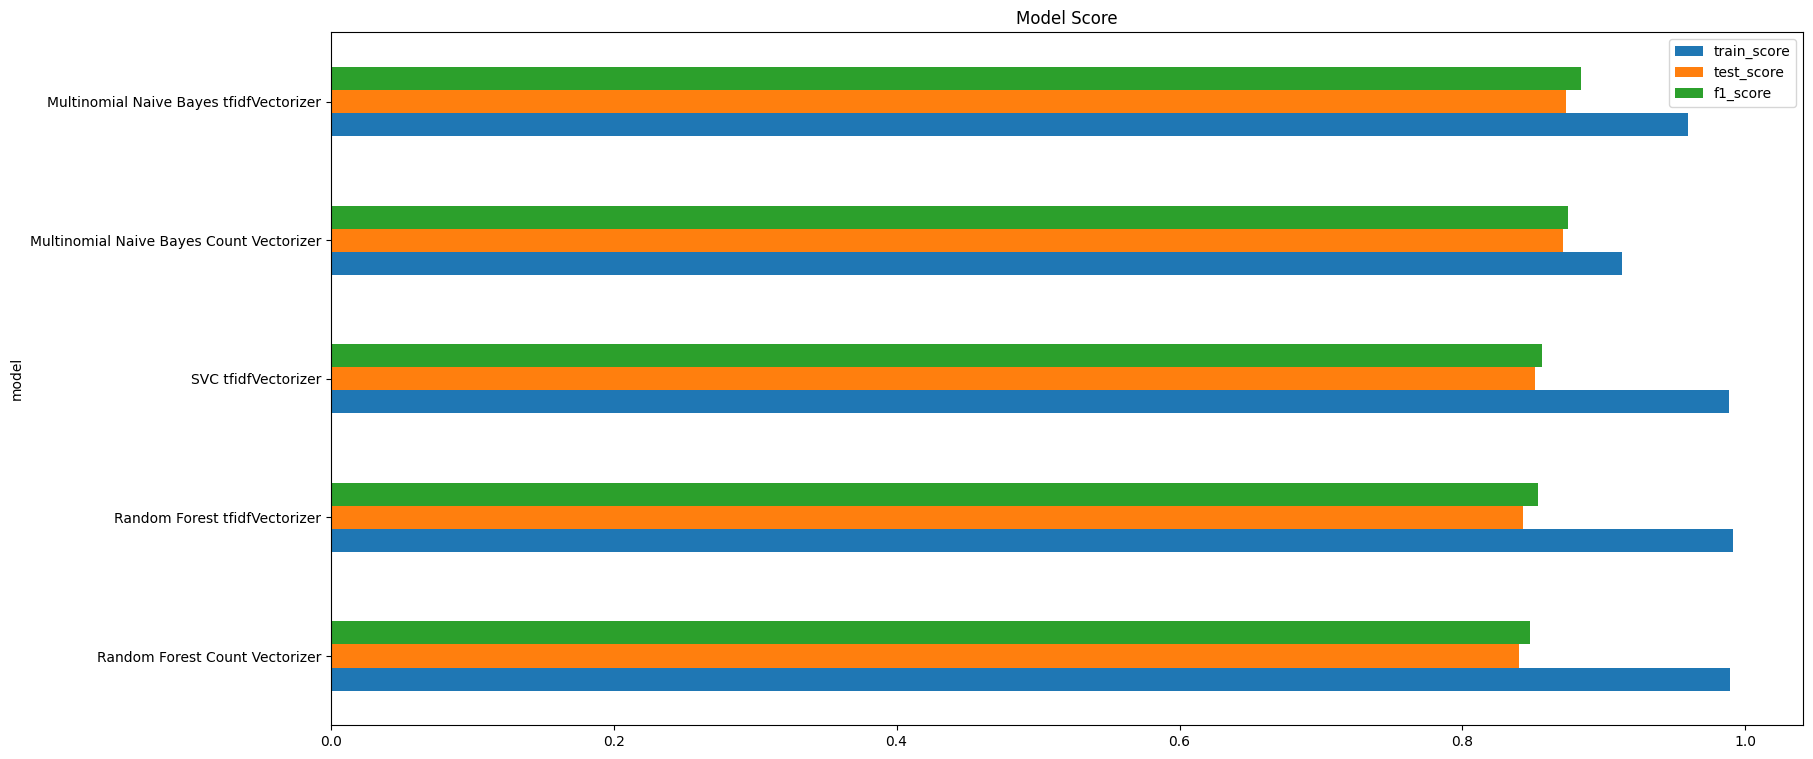

In [ ]:
# plot all score and sorting in hbar
results_df.sort_values(by='f1_score', ascending=True).plot(x='model', y=['train_score', 'test_score', 'f1_score'], kind='barh', figsize=(19,9))
plt.title('Model Score')

### Conclusion
After fine tune model parameters
found that `tfidfVectorizer`  has better performance to tokenize than `Count Vectorizer`
and in this case `Multinomial Naive Bayes` has better `f1_score` that `Random Forrest`

Also in this modeling we didn't mind that much about `false positice` or `false negative` because false predicted didn't cause serious trouble for seperate subreddit post

so i focus on `f1_score` for balance performance 

and the result indicate that `Multinomial Naive Bayes` with tokenizer `tfidfVectorizer`
with 
```
{'mnb__alpha': 2, 'tfidf__max_df': 0.9, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
```
parameters make best performance 


Recommend for further improvement
- remove images post if we focus on NLPs
- add bags of focus words that included in IronMan universe eg. characters name, actors name, quote in specific topic we focus
